# TMDB MOVIES DATA ANALYSIS

## Objectives
* Exploratory Data Analysis (EDA): Perform an initial exploration to understand trends.
* Advanced Filtering & Ranking: Identify the best and worst movies based on financial
  and popularity metrics.
* Franchise & Director Analysis: Assess how franchises and directors perform over time.
* Visualization & Insights: Present key findings using visualizations.

In [2]:
# locating the Spark installation
import findspark
findspark.init()

In [3]:
# Start a spark session for the data analysis
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("MovieAnalysis").getOrCreate()




In [4]:
# read the cleaned data from the parquet file
df = spark.read.parquet("../data/cleaned_movies_df.parquet")

# show the first 5 rows of the dataframe
df.show(5)

+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+--------------------+----------------+--------------------+--------------------+---------+--------------------+---------+
|    id|               title|             tagline|release_date|              genres|     collection_name|original_language|budget_musd|revenue_musd|production_companies|production_countries|vote_count|vote_average|popularity|runtime|            overview|spoken_languages|         poster_path|          cast_names|cast_size|           directors|crew_size|
+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+--------------------+----------------+-------------------

In [5]:
# Summary statistics
df.describe().show()

+-------+------------------+-------+--------------------+--------------------+--------------------+-----------------+------------------+------------------+--------------------+--------------------+------------------+-------------------+------------------+------------------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+------------------+
|summary|                id|  title|             tagline|              genres|     collection_name|original_language|       budget_musd|      revenue_musd|production_companies|production_countries|        vote_count|       vote_average|        popularity|           runtime|            overview|    spoken_languages|         poster_path|          cast_names|        cast_size|           directors|         crew_size|
+-------+------------------+-------+--------------------+--------------------+--------------------+-----------------+------------------+------------------+-----------

## KPI Implementation & Analysis

Filter and rank movies based on:
* Highest Revenue
* Highest Budget
* Highest Profit (Revenue - Budget)
* Lowest Profit (Revenue - Budget)
* Highest ROI (Revenue / Budget) (only movies with Budget ≥ 10M)
* Lowest ROI (only movies with Budget ≥ 10M)
* Most Voted Movies
* Highest Rated Movies (only movies with ≥10 votes)
* Lowest Rated Movies (only movies with ≥10 votes)
* Most Popular Movies

Define a User-Defined Function (UDF) to streamline ranking operations

In [6]:
# Function for the ranking of movies
from pyspark.sql.functions import col

def rank_movies(df, sort_col, ascending=False, filter_condition=None, top_n=10):
    if filter_condition:
        df = df.filter(filter_condition)
    return df.orderBy(col(sort_col).asc() if ascending else col(sort_col).desc()).limit(top_n)

In [7]:
# create profit and roi columns
from pyspark.sql.functions import when, expr

df = df.withColumn("profit", col("revenue_musd") - col("budget_musd"))\
       .withColumn("roi", when(col("budget_musd") >= 10, col("revenue_musd") / col("budget_musd")))


### Highest Revenue:

In [8]:
# Highest Revenue
rank_movies(df, "revenue_musd").show(5)

+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+--------------------+--------------------+--------------------+--------------------+---------+--------------------+---------+------------------+------------------+
|    id|               title|             tagline|release_date|              genres|     collection_name|original_language|budget_musd|revenue_musd|production_companies|production_countries|vote_count|vote_average|popularity|runtime|            overview|    spoken_languages|         poster_path|          cast_names|cast_size|           directors|crew_size|            profit|               roi|
+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+-----

### Highest Budget:


In [9]:
# Highest Budget
rank_movies(df, "budget_musd").show(5)

+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+--------------------+----------------+--------------------+--------------------+---------+--------------------+---------+------------------+-----------------+
|    id|               title|             tagline|release_date|              genres|     collection_name|original_language|budget_musd|revenue_musd|production_companies|production_countries|vote_count|vote_average|popularity|runtime|            overview|spoken_languages|         poster_path|          cast_names|cast_size|           directors|crew_size|            profit|              roi|
+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+--

### Highest Profit:

In [10]:
# Highest Profit
rank_movies(df, "profit").show(5)

+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+--------------------+--------------------+--------------------+--------------------+---------+--------------------+---------+------------------+------------------+
|    id|               title|             tagline|release_date|              genres|     collection_name|original_language|budget_musd|revenue_musd|production_companies|production_countries|vote_count|vote_average|popularity|runtime|            overview|    spoken_languages|         poster_path|          cast_names|cast_size|           directors|crew_size|            profit|               roi|
+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+-----

### Lowest Profit:

In [11]:
# Highest Profit
rank_movies(df, "profit", ascending=True).show(5)

+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+--------------------+----------------+--------------------+--------------------+---------+--------------------+---------+-------+-----------------+
|    id|               title|             tagline|release_date|              genres|     collection_name|original_language|budget_musd|revenue_musd|production_companies|production_countries|vote_count|vote_average|popularity|runtime|            overview|spoken_languages|         poster_path|          cast_names|cast_size|           directors|crew_size| profit|              roi|
+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+-----

### Highest ROI:

In [12]:
# Highest ROI (Budget ≥ 10M)
rank_movies(df, "roi", filter_condition="budget_musd >= 10").show(5)


+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+--------------------+--------------------+--------------------+--------------------+---------+--------------------+---------+-------+------------------+
|    id|               title|             tagline|release_date|              genres|     collection_name|original_language|budget_musd|revenue_musd|production_companies|production_countries|vote_count|vote_average|popularity|runtime|            overview|    spoken_languages|         poster_path|          cast_names|cast_size|           directors|crew_size| profit|               roi|
+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+---

### Lowest ROI:

In [13]:
# Lowest ROI (Budget ≥ 10M)
rank_movies(df, "roi", ascending=True, filter_condition="budget_musd >= 10").show(5)

+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+--------------------+--------------------------+--------------------+--------------------+---------+------------+---------+-------+-----------------+
|    id|               title|             tagline|release_date|              genres|     collection_name|original_language|budget_musd|revenue_musd|production_companies|production_countries|vote_count|vote_average|popularity|runtime|            overview|          spoken_languages|         poster_path|          cast_names|cast_size|   directors|crew_size| profit|              roi|
+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+-

### Most Voted Movies:

In [14]:
# Most Voted Movies
rank_movies(df, "vote_count").show(5)

+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+--------------------+--------------------+--------------------+--------------------+---------+--------------------+---------+-------+------------------+
|    id|               title|             tagline|release_date|              genres|     collection_name|original_language|budget_musd|revenue_musd|production_companies|production_countries|vote_count|vote_average|popularity|runtime|            overview|    spoken_languages|         poster_path|          cast_names|cast_size|           directors|crew_size| profit|               roi|
+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+---

### Highest Rated Movies:

In [15]:
# Highest Rated (only movies with ≥ 10 votes)
rank_movies(df, "vote_average", filter_condition="vote_count >= 10").show(5)

+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+--------------------+--------------------+--------------------+--------------------+---------+--------------------+---------+-------+------------------+
|    id|               title|             tagline|release_date|              genres|     collection_name|original_language|budget_musd|revenue_musd|production_companies|production_countries|vote_count|vote_average|popularity|runtime|            overview|    spoken_languages|         poster_path|          cast_names|cast_size|           directors|crew_size| profit|               roi|
+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+---

### Lowest Rated Movies

In [16]:
# Lowest Rated (only movies with ≥ 10 votes)
rank_movies(df, "vote_average", ascending=True, filter_condition="vote_count >= 10").show(5)

+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+--------------------+----------------+--------------------+--------------------+---------+---------------+---------+-------+-----------------+
|    id|               title|             tagline|release_date|              genres|     collection_name|original_language|budget_musd|revenue_musd|production_companies|production_countries|vote_count|vote_average|popularity|runtime|            overview|spoken_languages|         poster_path|          cast_names|cast_size|      directors|crew_size| profit|              roi|
+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+---------------

### Most Popular Movies

In [17]:
# Most Popular
rank_movies(df, "popularity").show(5)

+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+--------------------+--------------------------+--------------------+--------------------+---------+--------------------+---------+-------+-----------------+
|    id|               title|             tagline|release_date|              genres|     collection_name|original_language|budget_musd|revenue_musd|production_companies|production_countries|vote_count|vote_average|popularity|runtime|            overview|          spoken_languages|         poster_path|          cast_names|cast_size|           directors|crew_size| profit|              roi|
+------+--------------------+--------------------+------------+--------------------+--------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----

## Franchise vs. Standalone Movie Performance

Compare movie franchises (belongs_to_collection) vs. standalone movies in terms
of:
* Mean Revenue
* Median ROI
* Mean Budget Raised
* Mean Popularity
* Mean Rating

In [18]:
# function to compare franchise vs standalone movies
from pyspark.sql.functions import col, avg, when, expr, count, lit, percentile_approx, explode, split, trim, sum as _sum

def compare_franchise_vs_standalone(df):
    # Create is_franchise column
    df = df.withColumn("is_franchise", when(col("collection_name") != "", lit("Franchise")).otherwise("Standalone"))
    
    # Add ROI column if not already added
    df = df.withColumn("roi", when(col("budget_musd") >= 10, col("revenue_musd") / col("budget_musd")))
    
    # Group by is_franchise and compute metrics
    result = df.groupBy("is_franchise").agg(
        avg("revenue_musd").alias("mean_revenue"),
        percentile_approx("roi", 0.5).alias("median_roi"),
        avg("budget_musd").alias("mean_budget"),
        avg("popularity").alias("mean_popularity"),
        avg("vote_average").alias("mean_rating")
    )
    
    return result


In [19]:
# compare franchise vs standalone movies
compare_franchise_vs_standalone(df).show(truncate=False)


+------------+------------------+-----------------+-----------+---------------+-----------------+
|is_franchise|mean_revenue      |median_roi       |mean_budget|mean_popularity|mean_rating      |
+------------+------------------+-----------------+-----------+---------------+-----------------+
|Franchise   |1682.643125       |7.708647058823529|219.875    |33.03605       |7.3798125        |
|Standalone  |1765.1399999999999|7.91325          |180.0      |47.7778        |7.438000000000001|
+------------+------------------+-----------------+-----------+---------------+-----------------+



## Most Successful Franchises & Directors

Find the Most Successful Movie Franchises based on:
* Total number of movies in franchise
* Total & Mean Budget
* Total & Mean Revenue
* Mean Rating

In [20]:
# Function for analysing sucessful franchises
def analyze_successful_franchises(df):
    # Filter only franchise movies (non-empty collection_name)
    franchise_df = df.filter(col("collection_name") != "")

    # Group by franchise and compute metrics
    result = franchise_df.groupBy("collection_name").agg(
        count("*").alias("movie_count"),
        _sum("budget_musd").alias("total_budget_musd"),
        avg("budget_musd").alias("mean_budget_musd"),
        _sum("revenue_musd").alias("total_revenue_musd"),
        avg("revenue_musd").alias("mean_revenue_musd"),
        avg("vote_average").alias("mean_rating")
    ).orderBy(col("total_revenue_musd").desc())

    return result

In [21]:
analyze_successful_franchises(df).show(truncate=False)


+-----------------------------------+-----------+-----------------+----------------+------------------+------------------+------------------+
|collection_name                    |movie_count|total_budget_musd|mean_budget_musd|total_revenue_musd|mean_revenue_musd |mean_rating       |
+-----------------------------------+-----------+-----------------+----------------+------------------+------------------+------------------+
|The Avengers Collection            |4          |1241.0           |310.25          |7776.080000000001 |1944.0200000000002|7.8614999999999995|
|Star Wars Collection               |2          |445.0            |222.5           |3400.92           |1700.46           |7.02              |
|Jurassic Park Collection           |2          |320.0            |160.0           |2982.01           |1491.005          |6.615             |
|Avatar Collection                  |1          |237.0            |237.0           |2923.71           |2923.71           |7.588             |
|Froze

Find the Most Successful Directors based on:
* Total Number of Movies Directed
* Total Revenue
* Mean Rating

In [22]:
# Function for analysing sucessful directors
def analyze_successful_directors(df):
    # Split string into array and trim whitespace
    directors_df = df.withColumn("director", explode(split(col("directors"), "\\|"))).withColumn("director", trim(col("director")))

    # Group by individual director
    result = directors_df.groupBy("director").agg(
        count("*").alias("movie_count"),
        _sum("revenue_musd").alias("total_revenue_musd"),
        avg("vote_average").alias("mean_rating")
    ).orderBy(col("total_revenue_musd").desc())

    return result



In [23]:
analyze_successful_directors(df).show(truncate=False)


+---------------+-----------+------------------+-----------+
|director       |movie_count|total_revenue_musd|mean_rating|
+---------------+-----------+------------------+-----------+
|James Cameron  |2          |5187.87           |7.7465     |
|Joe Russo      |2          |4851.860000000001 |8.2175     |
|Anthony Russo  |2          |4851.860000000001 |8.2175     |
|Joss Whedon    |2          |2924.2200000000003|7.5055     |
|Chris Buck     |2          |2727.9            |7.248      |
|Jennifer Lee   |2          |2727.9            |7.248      |
|J.J. Abrams    |1          |2068.22           |7.262      |
|Colin Trevorrow|1          |1671.54           |6.693      |
|Jon Favreau    |1          |1662.02           |7.11       |
|James Wan      |1          |1515.4            |7.226      |
|Ryan Coogler   |1          |1349.93           |7.4        |
|David Yates    |1          |1341.51           |8.087      |
|Rian Johnson   |1          |1332.7            |6.778      |
|J.A. Bayona    |1      

## Data Visualisation

Visualise:
* Revenue vs. Budget Trends
* ROI Distribution by Genre     
* Popularity vs. Rating
* Yearly Trends in Box Office Performance
* Comparison of Franchise vs. Standalone Success

In [24]:
# conveting the Spark DataFrame to Pandas DataFrame for further analysis
def to_pandas(df, sample_frac=1.0):
    return df.sample(fraction=sample_frac).toPandas()


### Revenue vs. Budget Trend

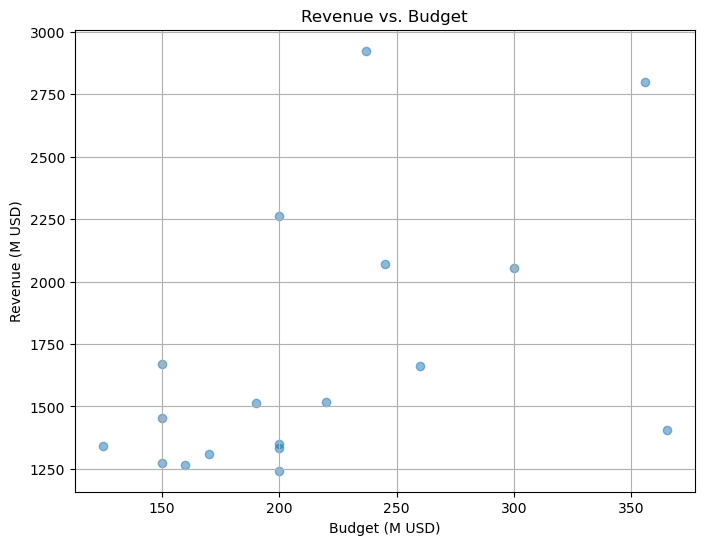

In [30]:
import matplotlib.pyplot as plt

# Prepare data
rev_budget_df = df.select("budget_musd", "revenue_musd").filter((col("budget_musd") > 0) & (col("revenue_musd") > 0))
pd_rev_budget = to_pandas(rev_budget_df)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(pd_rev_budget["budget_musd"], pd_rev_budget["revenue_musd"], alpha=0.5)
plt.xlabel("Budget (M USD)")
plt.ylabel("Revenue (M USD)")
plt.title("Revenue vs. Budget")
plt.grid(True)
plt.show()


### ROI Distribution by Genre

<Figure size 1000x600 with 0 Axes>

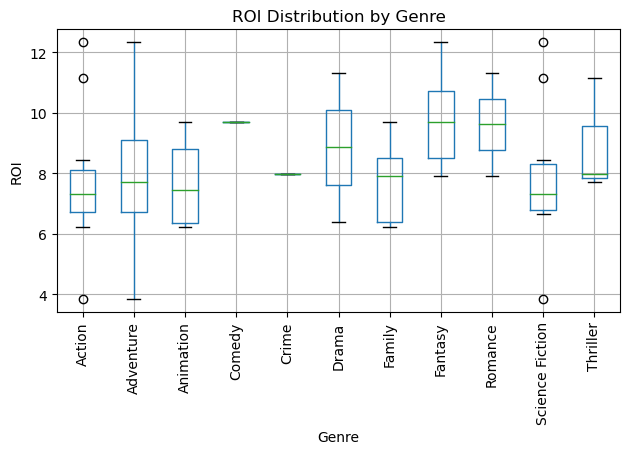

In [31]:
from pyspark.sql.functions import explode, split

# Explode genres into separate rows
roi_genre_df = df.withColumn("genre", explode(split(col("genres"), "\\|")))\
                 .select("genre", "roi")\
                 .filter(col("roi").isNotNull())

pd_roi_genre = to_pandas(roi_genre_df)

# Plot
plt.figure(figsize=(10, 6))
pd_roi_genre.boxplot(by="genre", column=["roi"], rot=90)
plt.title("ROI Distribution by Genre")
plt.suptitle("")  # remove automatic title
plt.xlabel("Genre")
plt.ylabel("ROI")
plt.grid(True)
plt.tight_layout()
plt.show();


### Popularity vs. Rating

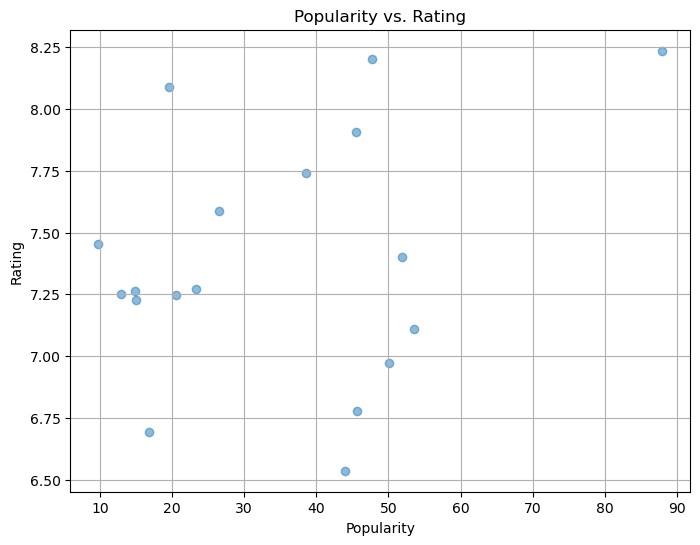

In [32]:
pop_rating_df = df.select("popularity", "vote_average").filter((col("popularity").isNotNull()) & (col("vote_average").isNotNull()))
pd_pop_rating = to_pandas(pop_rating_df)

plt.figure(figsize=(8, 6))
plt.scatter(pd_pop_rating["popularity"], pd_pop_rating["vote_average"], alpha=0.5)
plt.xlabel("Popularity")
plt.ylabel("Rating")
plt.title("Popularity vs. Rating")
plt.grid(True)
plt.show()


### Yearly Trends in Box Office Performance

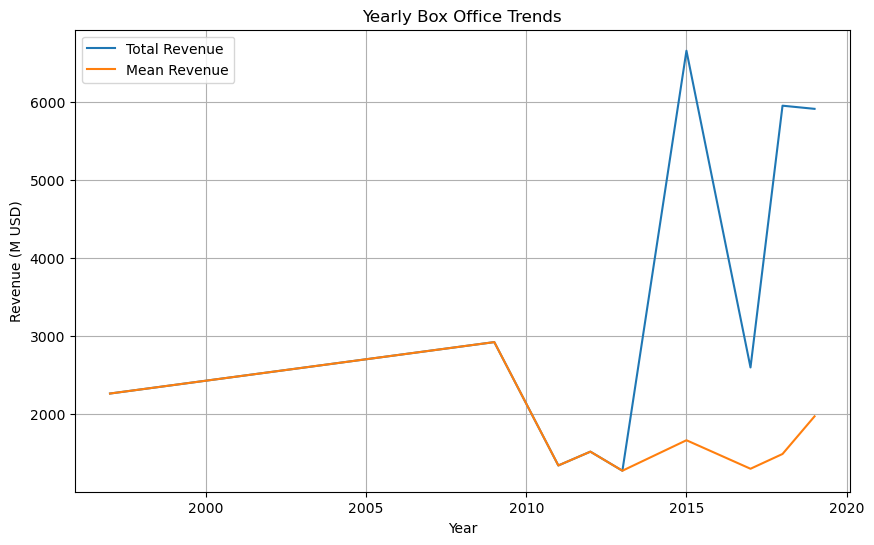

In [33]:
from pyspark.sql.functions import year

# Extract year
year_df = df.withColumn("year", year("release_date"))\
            .groupBy("year")\
            .agg(_sum("revenue_musd").alias("total_revenue"),
                 avg("revenue_musd").alias("mean_revenue"))\
            .orderBy("year")

pd_year = to_pandas(year_df)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(pd_year["year"], pd_year["total_revenue"], label="Total Revenue")
plt.plot(pd_year["year"], pd_year["mean_revenue"], label="Mean Revenue")
plt.xlabel("Year")
plt.ylabel("Revenue (M USD)")
plt.title("Yearly Box Office Trends")
plt.legend()
plt.grid(True)
plt.show()


### Franchise vs. Standalone Comparison

In [ ]:

def plot_avg_metrics_by_franchise(df, metrics, title, ylabel):
    """
    Plots a clustered bar chart comparing average metrics between franchise and standalone movies.

    Parameters:
        df (DataFrame): Spark DataFrame with movie data.
        metrics (list): List of metric column names (strings) to compute averages for.
        title (str): Title for the plot.
        ylabel (str): Label for the y-axis (e.g., 'Average Value (in million USD)', 'Average Score', etc.).
    """
    # Mark if movie is part of a franchise
    summary_df = df.withColumn("is_franchise", (col("collection_name") != "") & col("collection_name").isNotNull())

    # Aggregate average values for selected metrics
    avg_exprs = [avg(metric).alias(f"average_{metric}") for metric in metrics]
    average_df = summary_df.groupBy("is_franchise").agg(*avg_exprs)

    # Convert to pandas for plotting
    average_pd = average_df.toPandas()
    average_pd["type"] = average_pd["is_franchise"].map({True: "Franchise", False: "Standalone"})
    average_pd.set_index("type", inplace=True)

    # Plot selected metrics
    avg_columns = [f"average_{metric}" for metric in metrics]
    average_pd[avg_columns].T.plot(kind="bar", figsize=(9, 6), width=0.7)

    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.grid(axis="y")
    plt.legend(title="Movie Type")
    plt.tight_layout()
    plt.show()


 ### Franchise vs. Standalone Comparison: ROI, Profit, Budget, Revenue

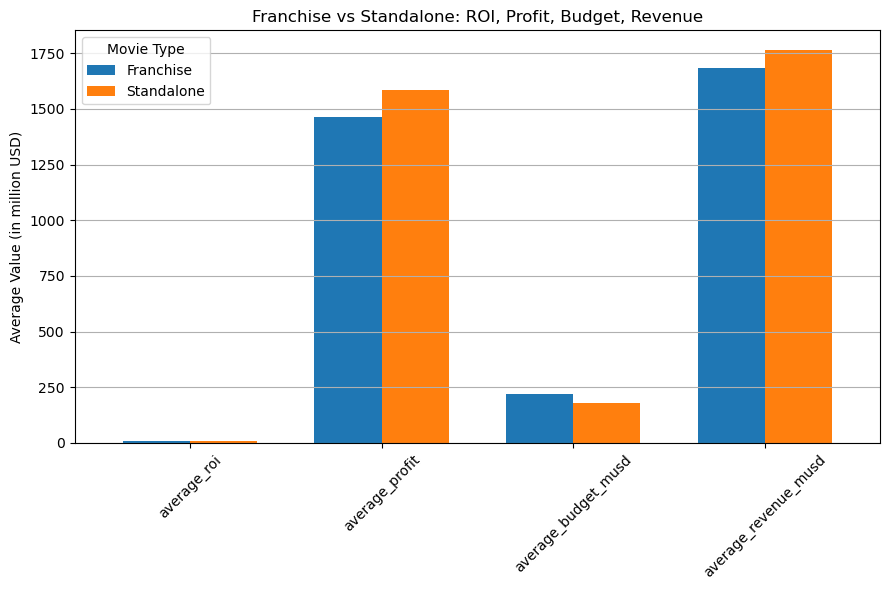

In [41]:

plot_avg_metrics_by_franchise(
    df,
    ["roi", "profit", "budget_musd", "revenue_musd"],
    title="Franchise vs Standalone: ROI, Profit, Budget, Revenue",
    ylabel="Average Value (in million USD)"
)


 ### Franchise vs. Standalone Comparison:  Popularity, Rating

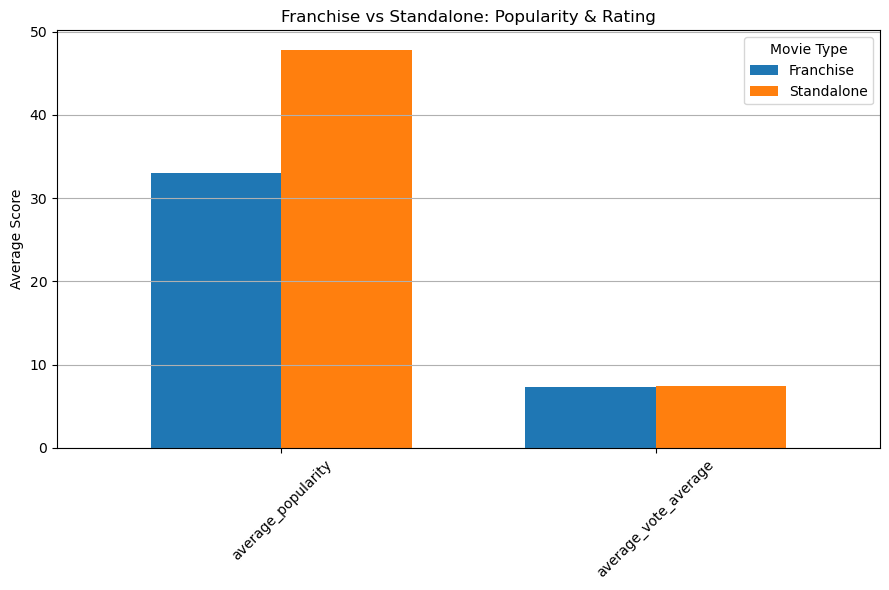

In [42]:
plot_avg_metrics_by_franchise(
    df,
    ["popularity", "vote_average"],
    title="Franchise vs Standalone: Popularity & Rating",
    ylabel="Average Score"
)


## Key Findings
### Best & Worst Performing Movies
1. Highest bugdeted movie is Avengers: Age of Ultron
2. Movie with the highest revenue is Avatar
3. Movie with the highest profit and ROI is Avatar
4. Movie with lowest profit and ROI is Avengers: Age of Ultron
5. The most popular movie is Avengers
6. Movie with the highest ratings is Avengers: Endgame


### Franchise vs. Standalone Movie Performance
1. Standalone movies have the highest average revenue, the highest median ROI and the high average popularity
2. Franchise movies have the highest average budget

### Most sucessful Franchise And Directors
1. The Franchise with the most number of movies is the Avengers Collection
2. The Franchise with the highest average and total budget is the Avengers Collection
3. The Franchise with the highest total and average revenue is the Avengers and the Avatar collection respectiveky
4. The Franchise with the highest average ratings is the Harry Potter collections
5. Diretors with highest number of movies are James Cameron, Joss Whedon, Anthony Russo, Joe Russo, Chris Buck, Jennifer Lee
6. The most sucessful director based on total revenue is James Cameron
7. The most succesful directors based on the average ratings are Joe Russo, Anthony Russo

